# Final project 

This notebook consist of the final project of the Kodilla bootcamp. 

Loading libraries

In [4]:
# data manipulation
import numpy as np
import pandas as pd
import datetime as dt
import time
from math import sqrt
from tqdm import tqdm
# import holidays

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature selection
from sklearn.feature_selection import RFECV

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# optimization and hyperparameters
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# interpretability of the model
import shap

# saving the model
import joblib

# settings -- graphics inside the jupiter notebook
%matplotlib inline 

# disable warnings
import warnings
warnings.filterwarnings('ignore')

# import holidays
import holidays

# import date from datetime
from datetime import date

## Description of the problem

Let's assume we work in the Data Science department of a bicycle rental company. Currently, the company is preparing as many bicycles at its stations as the average number of bicycles rented in the previous week and in the previous year.

An insufficient number of bicycles at the stands means a lost profit worth PLN 10, as this is the average profit from renting one bicycle on this route.

If there are too many bicycles at the station, we keep bicycles that do not generate profit, and previously we had to bring them - the average daily cost that we incur by not renting a bicycle is PLN 1.

Logistics processes in our company operate one week in advance. Therefore, we make a forecast for next week. This means that after Monday ends (i.e. we know how many bikes were rented that day), we make a forecast for Monday of the following week. These are nothing more than business conditions.

The data we will use comes from Oslo (Norway) and is saved in the file bikerides_day.csv.

 

##  Understanding the dataset

We are going to answer the question which variables influence our explained variable(s) and what steps we should take next:

    whether any variable is a data leak and should be removed,
    are the variables correlated with each other and convey the same information,
    Are there any gaps in the data and how to complete them,
    are there outliers/false values and how/should we replace them,
    how to transform data to make it "easier" for the model.


Loading data and setting the time variable

In [6]:
dataframe = pd.read_csv('bikerides_day.csv')
dataframe['Date'] = pd.to_datetime(dataframe['Date'])
dataframe

,Date,Volume,Rain,Temp
0,2016-11-17,933.0,9.0,2.1
1,2016-11-18,1197.0,6.7,3.9
2,2016-11-19,243.0,5.4,2.0
3,2016-11-20,234.0,3.9,2.8
4,2016-11-21,2148.0,7.3,2.8
...,...,...,...,...
1268,2020-05-16,2484.0,0.0,6.6
1269,2020-05-17,1509.0,0.0,9.1
1270,2020-05-18,5775.0,0.0,9.3
1271,2020-05-19,6741.0,0.0,9.7


We have time data with a daily frequency and for each day we have the number of cyclists and weather data on those days, which are precipitation and temperature. We assume that the weather will be perfect in the future. Now let's answer a few questions that will help us prepare the data.

### Are there any missing data?

In [7]:
dataframe.isnull().mean()*100

Date      0.0
Volume    0.0
Rain      0.0
Temp      0.0
dtype: float64

There are no missing data for indexes, but this does not mean that there are no missing data elsewhere.



### Are there duplicates for the date?

Is there one date in two different observations.

In [8]:
dataframe.loc[dataframe.duplicated(subset='Date', keep=False), :]

,Date,Volume,Rain,Temp


### Are the dates sorted?

Dates should be sorted from oldest to newest. We check whether the data in our set is equal to the sorted ones, i.e. whether our raw data is already sorted.

In [9]:
(dataframe['Date'] == dataframe['Date'].sort_values()).all()

True

### Are all the dates there?

The fact that there are no missing data in our set does not mean that they do not exist. Since we have daily data, any day from the oldest to the newest will be missing.

To do this, we create a range of all dates that should appear in the set. We use the date_range function from the Pandas library, providing the minimum and maximum date for it. We then use the difference method to indicate what dates are missing from the dataset.



In [10]:
pd.date_range(start=dataframe['Date'].min(), end=dataframe['Date'].max()).difference(dataframe['Date'])

DatetimeIndex(['2017-10-16', '2019-01-14', '2019-06-07', '2019-06-08',
               '2019-06-09', '2019-06-10', '2019-08-14', '2019-08-15'],
              dtype='datetime64[ns]', freq=None)

However, there are missing values. Let's check if this is true and try to display the first missing value.



In [11]:
dataframe.loc[dataframe['Date']=='2017-10-16',:]

,Date,Volume,Rain,Temp


No value. Let's check if the value is for the previous day.



In [12]:
dataframe.loc[dataframe['Date']=='2017-10-15',:]

,Date,Volume,Rain,Temp
332,2017-10-15,843.0,0.0,9.6


We should fill in the missing data.

### What is the distribution of our data?

We begin with the method describe().

In [13]:
dataframe.describe()

,Volume,Rain,Temp
count,1273.000000,1273.000000,1273.000000
mean,2609.344855,1.945640,6.783975
std,1968.623825,4.505151,7.726084
min,63.000000,0.000000,-11.400000
25%,1185.000000,0.000000,0.700000
50%,2073.000000,0.000000,5.500000
75%,3801.000000,1.400000,13.400000
max,8679.000000,39.500000,25.900000


To extend this analysis, let's add histograms and boxplots for numeric variables (that is, for all variables except date).



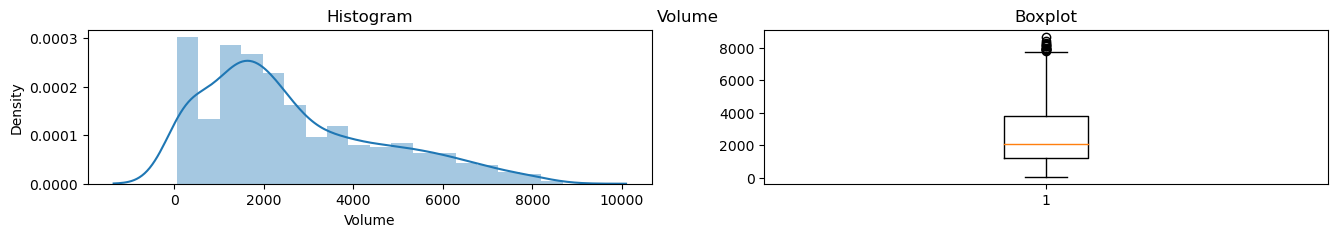

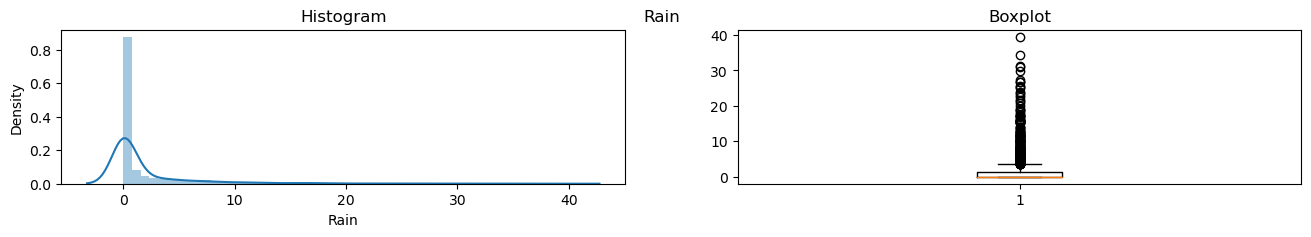

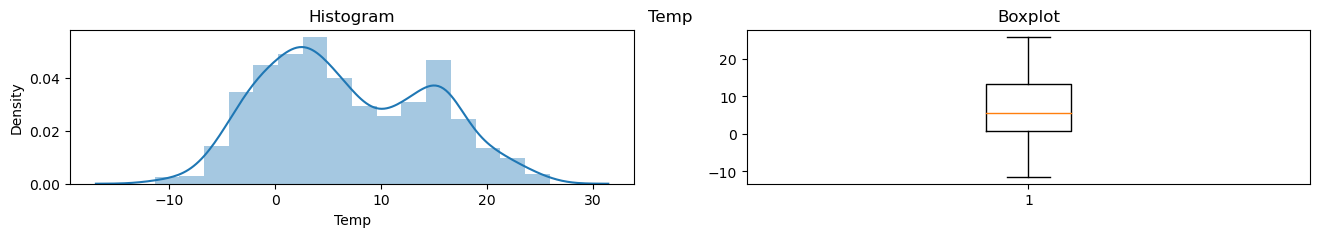

In [15]:
for variable in dataframe.select_dtypes(include=np.number).columns:
    fig = plt.figure(figsize=(16, 2))
    fig.suptitle(variable, fontsize=12)
    plt.subplot(121)
    sns.distplot(dataframe[variable], kde=True, rug=False)
    plt.title('Histogram')
    plt.subplot(122)
    plt.boxplot(dataframe[variable])
    plt.title('Boxplot')
    plt.show()

Our explained variable y is not normally distributed. To bring such a variable into a Gaussian distribution, it is worth, for example, logarithmizing this variable, we can use PoweTransformer from the skcikit-learn library.

For rain, we see that there are a lot of outliers, and this is because there is usually no rainfall.

As for the temperature, you can see that it is most often around 7°C or 15°C.

Now it's time to check how the number of rented bikes is explained by itself over time (seasonality, trend) and how it depends on external variables such as rainfall or temperature.

### What is the number of bikes rented over time?

Let's visualize the number of rented bikes on individual days. We can expect some weekly seasonality (there are on average more rentals on one day of the week than another), so let's add a seven-day moving average.

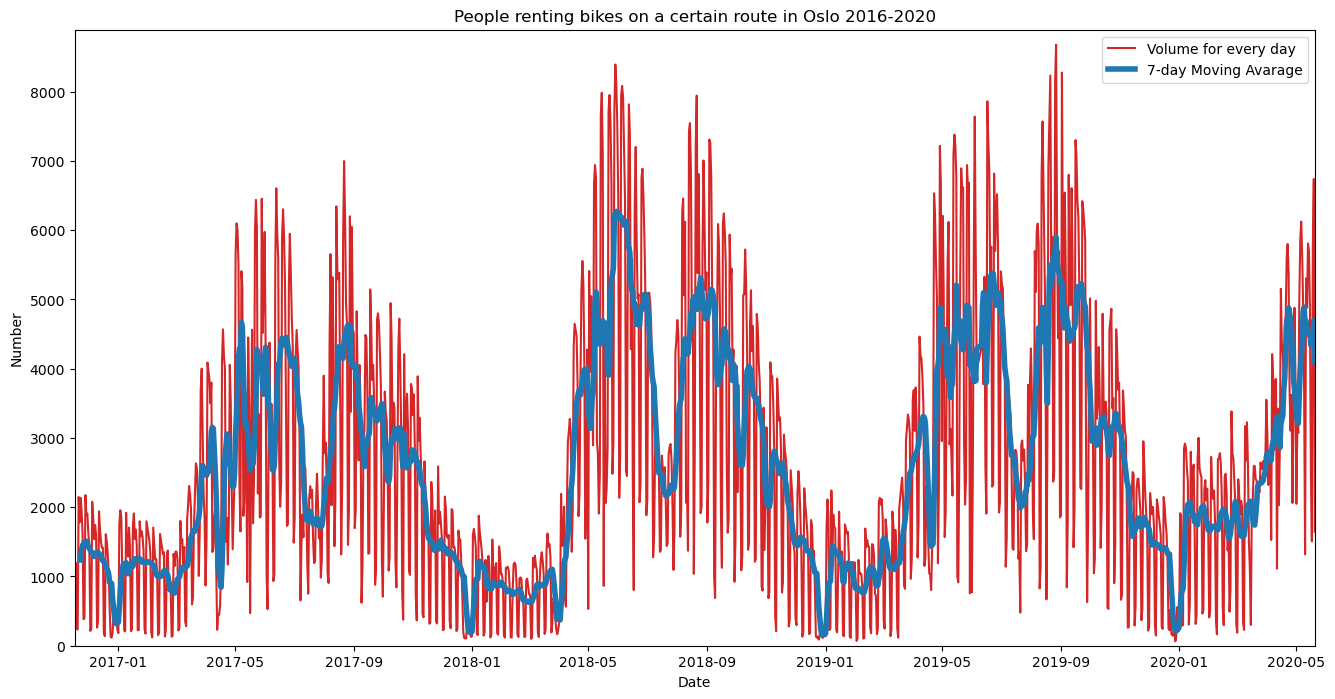

In [16]:
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(dataframe['Date'], dataframe['Volume'],
         color='tab:red', label='Volume for every day')
plt.plot(dataframe['Date'], dataframe['Volume'].rolling(7).mean(),
         color='tab:blue', linewidth=4, label='7-day Moving Avarage')
plt.title('People renting bikes on a certain route in Oslo 2016-2020')
plt.xlabel('Date')
plt.ylabel('Number')
plt.xlim([dataframe['Date'].min(), dataframe['Date'].max()])
plt.ylim([0, dataframe['Volume'].max()*1.025])
plt.legend(loc='upper right')
plt.show()

There is a significant variation in the number of bikes rented, which is probably the reason for the weekly seasonality. If we counted all the 'hills' in a given year, we would get the number of weeks in a year. Moreover, there is also some annual seasonality (it is worth looking at the moving average here), the value of rented bicycles increases until the holidays, only to fall and then increase again. We don't have to look at the temperature to guess that there will be fewer bike rentals in winter than in the warm months.

In [20]:
full_years = dataframe.loc[(dataframe['Date'] >= '2017-01-01') & (dataframe['Date'] < '2020-01-01')].copy()
full_years['year'] = [d.year for d in full_years['Date']]
full_years['month'] = [d.strftime('%b') for d in full_years['Date']]
full_years['weekday'] = [d.strftime('%A') for d in full_years['Date']]
full_years

,Date,Volume,Rain,Temp,year,month,weekday
45,2017-01-01,183.0,0.0,1.1,2017,Jan,Sunday
46,2017-01-02,1752.0,0.0,-2.8,2017,Jan,Monday
47,2017-01-03,1956.0,0.0,-2.5,2017,Jan,Tuesday
48,2017-01-04,1854.0,0.0,-3.1,2017,Jan,Wednesday
49,2017-01-05,1113.0,0.0,-10.1,2017,Jan,Thursday
...,...,...,...,...,...,...,...
1127,2019-12-27,342.0,0.0,-4.9,2019,Dec,Friday
1128,2019-12-28,63.0,0.0,-1.2,2019,Dec,Saturday
1129,2019-12-29,126.0,5.9,4.4,2019,Dec,Sunday
1130,2019-12-30,558.0,0.0,5.5,2019,Dec,Monday


Then let's aggregate the data set to the year/month level and use the average as the aggregation function.

In [21]:
full_years_monthly = full_years.groupby(['year', 'month'])[['Volume']].mean()
full_years_monthly.reset_index(inplace=True)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

full_years_monthly['month'] = pd.Categorical(full_years_monthly['month'], categories=months, ordered=True)
full_years_monthly.sort_values(by=['year', 'month'], inplace=True)
display(full_years_monthly.head(3))
display(full_years_monthly.tail(3))

,year,month,Volume
4,2017,Jan,1202.225806
3,2017,Feb,980.250000
7,2017,Mar,1703.419355


,year,month,Volume
34,2019,Oct,3204.967742
33,2019,Nov,1852.500000
26,2019,Dec,1035.580645


We have created new data sets that will help us analyze data in terms of seasonality or trend. 

First, let's use the second data frame and make a line chart of the average number of bike rentals depending on the month for 2017, 2018 and 2019.

2017
2018
2019


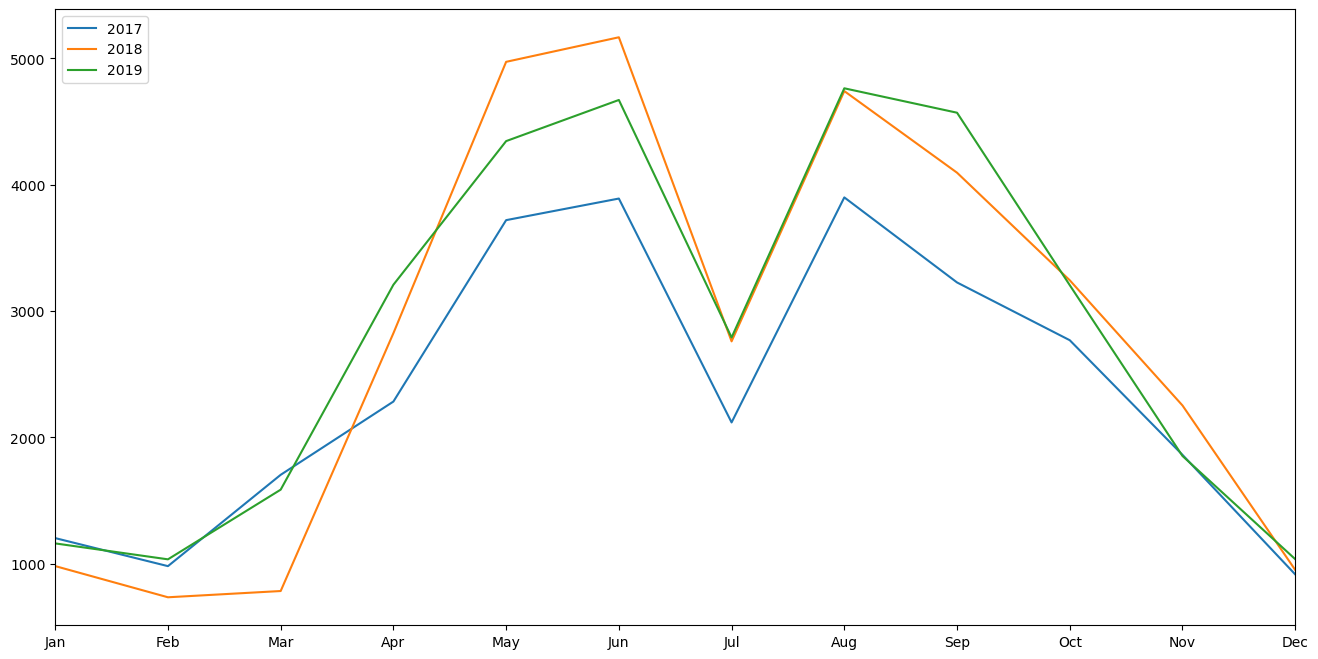

In [22]:
plt.figure(figsize=(16, 8), dpi=100)
for year in full_years['year'].unique():
    plt.plot(full_years_monthly.loc[full_years_monthly['year']==year, 'month'],
             full_years_monthly.loc[full_years_monthly['year']==year, 'Volume'], label=year)
    print(year)
plt.legend(loc='upper left')
plt.xlim(['Jan', 'Dec'])
plt.show()

Note that the dependencies are constant for years. In cold months, such as December, January and February, we see the lowest average number of bikes rented. Another interesting relationship is what we have already seen, for July there is a significant drop, perhaps it is related to the fact that Oslo residents leave the city for their long-awaited holidays at this time. 


We will check seasonality using boxplots.


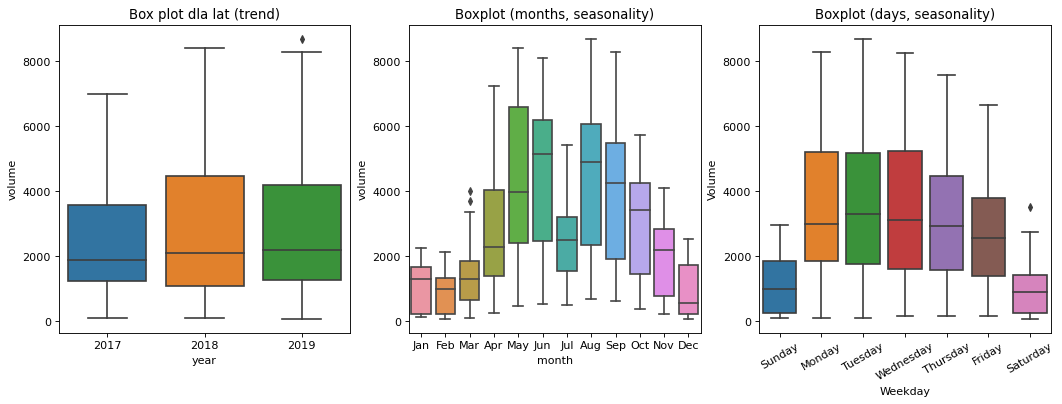

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=80)
sns.boxplot(x='year', y='Volume', data=full_years, ax=axes[0]).set(
    xlabel='year',
    ylabel='volume'
)

axes[0].set_title('Box plot dla lat (trend)')
sns.boxplot(x='month', y='Volume', data=full_years, ax=axes[1]).set(
    xlabel='month',
    ylabel='volume'
)

axes[1].set_title('Boxplot (months, seasonality)')
sns.boxplot(x='weekday', y='Volume', data=full_years, ax=axes[2]).set(
    xlabel='Weekday',
    ylabel='Volume'
)

axes[2].set_title('Boxplot (days, seasonality)')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=30)
plt.show()

Trend – there is no indication that the trend is still in force, but the number of rented bicycles in 2017 was lower.
    Annual seasonality – we have already explored this topic.
    Weekly seasonality – hence the variance. There are more bikes rented on weekdays than on weekends. Going further, you can see the differences between the beginning of the week (Monday) and the end of the working week (Friday).

Apart from typical days of the week, a holiday may occur and sometimes it occurs on the same day of the week every year (e.g. Easter), or it may occur on different days (Independence Day, Christmas).

Let's use the holidays library and add holidays for Norway. It is important to note that Sunday ("Søndag") is treated as a holiday, we do not take this holiday into account. We create the get_holiday function, which we apply to the previously created full_years data frame and thanks to it we obtain a new Holiday variable with the indicated holiday (or not, if there was none - most of the period) for a specific date.



In [25]:
holidays_Norway = holidays.NO()

def get_holiday(row):
    holidays = holidays_Norway.get(row['Date'])
    if holidays == None:
        return np.NaN

    # Søndag, czyli niedziela jest traktowana jako święto - usuwamy to święto
    elif holidays != 'Søndag':

        # Usunięcie niedzieli nakładającej się z innymi świętami
        if 'Søndag' in holidays:
            holidays = holidays.replace('Søndag', '')
            holidays = holidays.replace(',', '')
            holidays = holidays.lstrip().rstrip()
            return holidays
        else:
            return holidays
    else:
        return np.NaN
full_years['Holiday'] = full_years.apply(get_holiday, axis=1)
print('Unique holidays:')
print(full_years['Holiday'].value_counts())
full_years

Unique holidays:
Første nyttårsdag        3
Skjærtorsdag             3
Langfredag               3
Første påskedag          3
Andre påskedag           3
Arbeidernes dag          3
Grunnlovsdag             3
Kristi himmelfartsdag    3
Første juledag           3
Andre juledag            3
Første pinsedag          2
Andre pinsedag           2
Name: Holiday, dtype: int64


,Date,Volume,Rain,Temp,year,month,weekday,Holiday
45,2017-01-01,183.0,0.0,1.1,2017,Jan,Sunday,Første nyttårsdag
46,2017-01-02,1752.0,0.0,-2.8,2017,Jan,Monday,NaN
47,2017-01-03,1956.0,0.0,-2.5,2017,Jan,Tuesday,NaN
48,2017-01-04,1854.0,0.0,-3.1,2017,Jan,Wednesday,NaN
49,2017-01-05,1113.0,0.0,-10.1,2017,Jan,Thursday,NaN
...,...,...,...,...,...,...,...,...
1127,2019-12-27,342.0,0.0,-4.9,2019,Dec,Friday,NaN
1128,2019-12-28,63.0,0.0,-1.2,2019,Dec,Saturday,NaN
1129,2019-12-29,126.0,5.9,4.4,2019,Dec,Sunday,NaN
1130,2019-12-30,558.0,0.0,5.5,2019,Dec,Monday,NaN


Below is a list of public holidays in Norway

    Første juledag - First day of Christmas
    Andre juledag - Second Day of Christmas
    Første nyttårsdag - New Year
    Skjærtorsdag - Maundy Thursday
    Langfredag ​​- Good Friday
    Første påskedag - The first day of Easter
    Andre påskedag - The second day of Easter
    Arbeidernes dag - Labor Day
    Grunnlovsdag - Constitution Day
    Kristi himmelfartsdag - Ascension Day
    Første pinsedag - First day of Pentecost
    Andre pinsedag - Second day of Pentecost

We will examine the impact of holidays on bicycle rentals. We will use a box plot for the range of months in which a holiday occurred, distinguishing whether it was a holiday or not in given months.



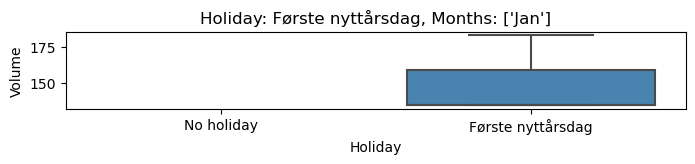

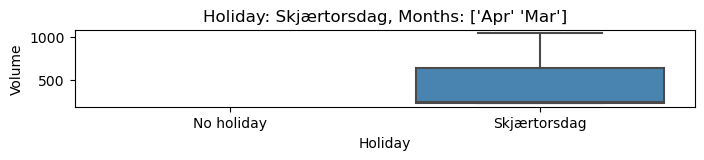

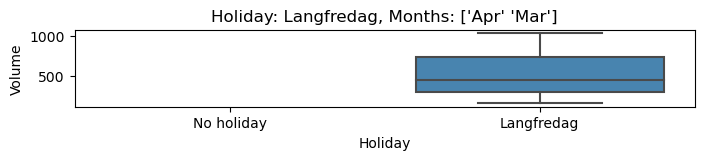

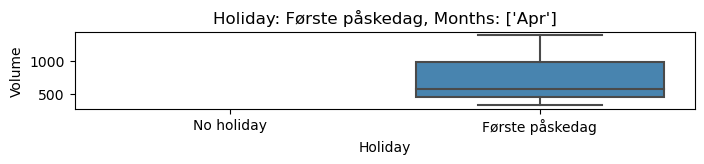

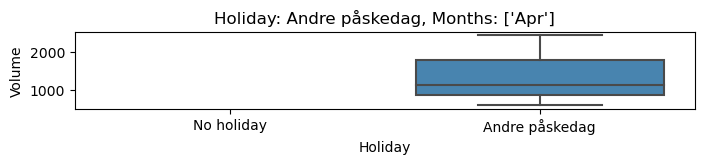

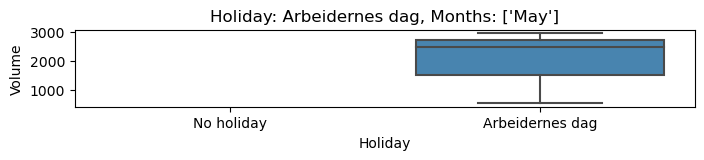

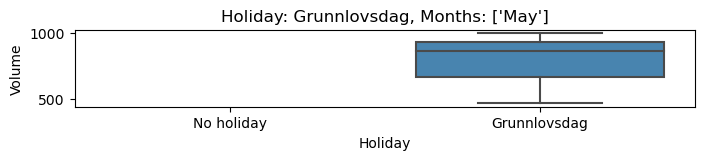

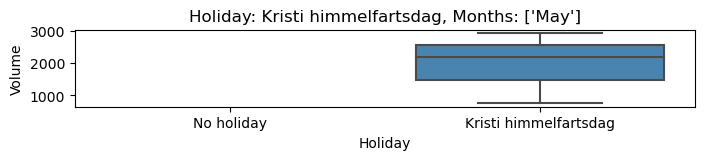

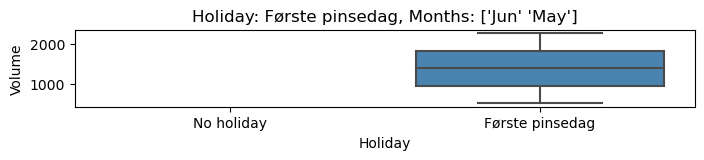

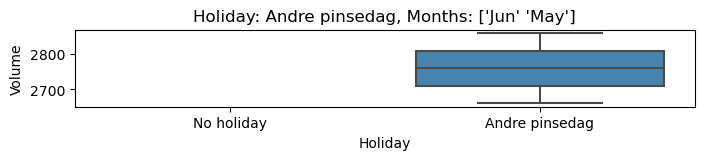

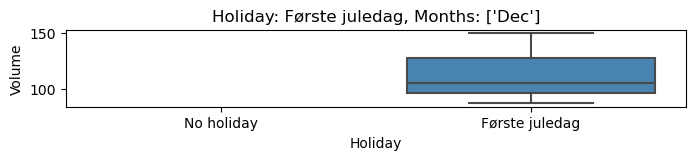

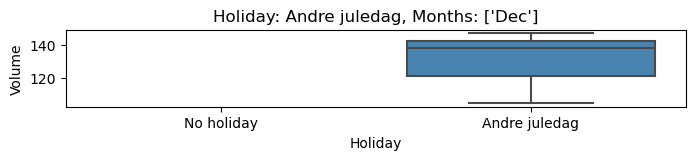

In [26]:
for unique_holiday in full_years['Holiday'].dropna().unique():

    # Filtering the months in which this holiday occurred, removing other holidays in the same period
    month_holiday = full_years.loc[full_years['Holiday']==unique_holiday, 'month'].unique()
    selected_holiday = full_years.loc[((full_years['month'].isin(month_holiday))&\
                                       (full_years['Holiday'].isin([np.NaN, unique_holiday]))), :].copy()
    selected_holiday['Holiday'].fillna('Brak święta', inplace=True)

    # Ploting the boxplot
    plt.figure(figsize=(8, 1))
    sns.boxplot(x=selected_holiday['Holiday'], y=selected_holiday['Volume'],
                palette="Blues", order=['No holiday', unique_holiday])
    plt.title(f'Holiday: {unique_holiday}, Months: {month_holiday}')
    plt.show()

All holidays are like weekends, a significantly smaller number of rentals is noticeable. Let's check the box plot if we combined all holidays into one value, i.e. separated the situations - there is a holiday or there is no holiday, no matter what holiday.



In [21]:
full_years.loc[~full_years['Holiday'].isnull(), 'Holiday'] = 1
full_years.fillna(0, inplace=True)
full_years

,Date,Volume,Rain,Temp,year,month,weekday,Holiday
45,2017-01-01,183.0,0.0,1.1,2017,Jan,Sunday,1
46,2017-01-02,1752.0,0.0,-2.8,2017,Jan,Monday,0
47,2017-01-03,1956.0,0.0,-2.5,2017,Jan,Tuesday,0
48,2017-01-04,1854.0,0.0,-3.1,2017,Jan,Wednesday,0
49,2017-01-05,1113.0,0.0,-10.1,2017,Jan,Thursday,0
...,...,...,...,...,...,...,...,...
1127,2019-12-27,342.0,0.0,-4.9,2019,Dec,Friday,0
1128,2019-12-28,63.0,0.0,-1.2,2019,Dec,Saturday,0
1129,2019-12-29,126.0,5.9,4.4,2019,Dec,Sunday,0
1130,2019-12-30,558.0,0.0,5.5,2019,Dec,Monday,0


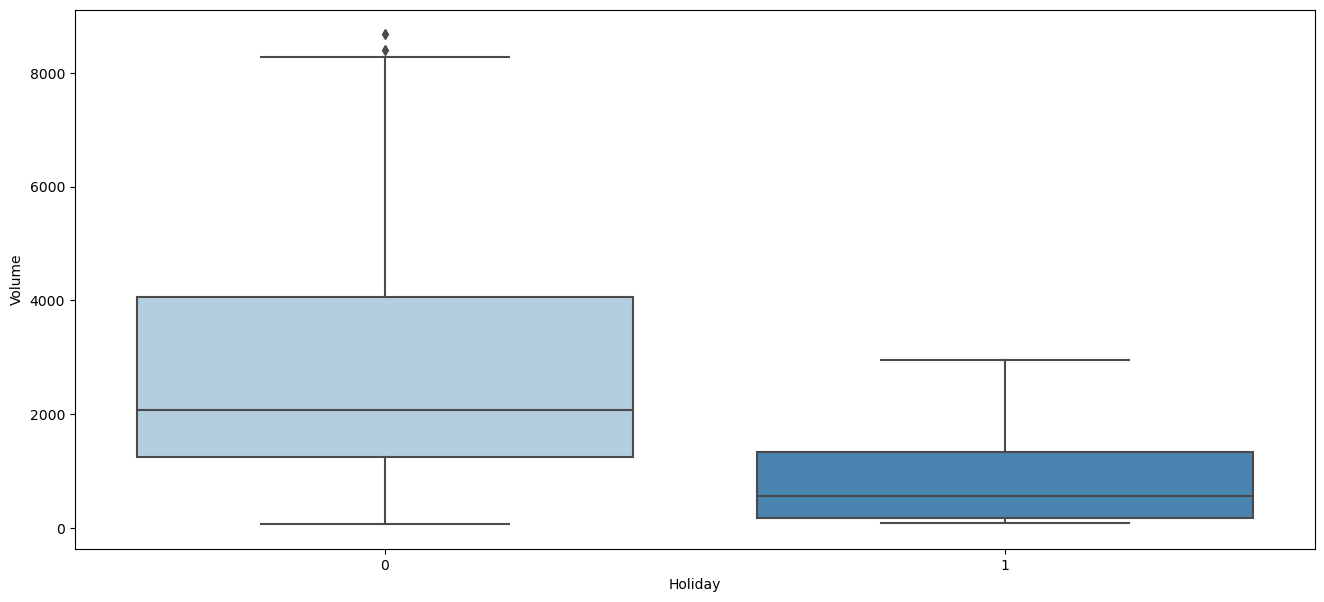

In [22]:
plt.figure(figsize=(16, 7))
sns.boxplot(x=full_years['Holiday'], y=full_years['Volume'], palette="Blues")
plt.show()

The holiday has a significant impact on the number of bikes rented.

Let us also check the dependence of observations on a series of delays. A plot of series observations versus lags is usually used to check for autocorrelation. If any pattern is noticeable in the scatterplot, then we can believe that the series is autocorrelated. If the points are arranged randomly, then it will be random white noise.

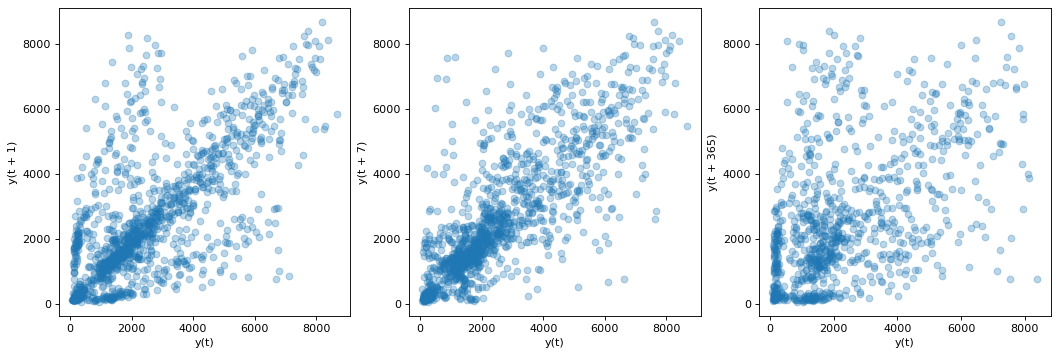

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=80)
pd.plotting.lag_plot(dataframe['Volume'], lag=1, ax=axes[0], alpha=0.3)
pd.plotting.lag_plot(dataframe['Volume'], lag=7, ax=axes[1], alpha=0.3)
pd.plotting.lag_plot(dataframe['Volume'], lag=365, ax=axes[2], alpha=0.3)
plt.show()

Due to the fact that we have weekly seasonality, today's value is more similar to the value from the previous week than to the value from yesterday.

### The impact of weather on the number of cyclists

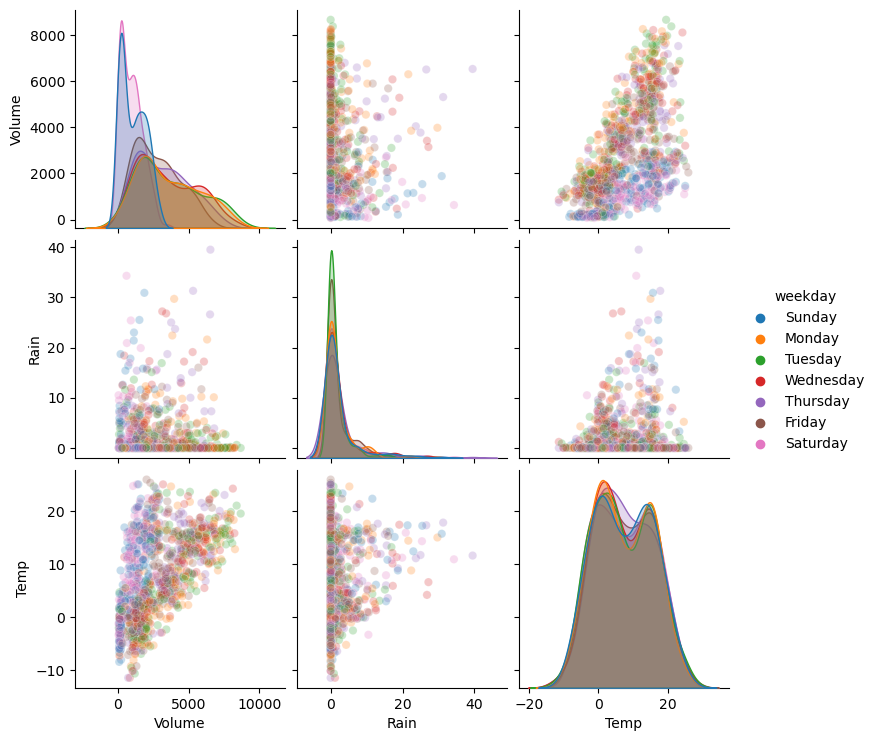

In [24]:
sns.pairplot(full_years[['Volume', 'Rain', 'Temp', 'weekday']], hue='weekday', kind='scatter', plot_kws={'alpha':0.25})
plt.show()

The correlation between temperature and the number of bikes rented is clear. This situation does not occur for rainfall - but we will leave this variable.



## Data preparation

We already know the problems with our data set and we also know what affects the number of rented bikes. So let's transform the data set in a way to deal with the problems and make it easier for the model to make predictions. We will use Pipeline for this, the processing process will be more automatic and ready to be implemented in production, and we will also be sure that there will be no data leakage.

In [25]:
dataframe

,Date,Volume,Rain,Temp
0,2016-11-17,933.0,9.0,2.1
1,2016-11-18,1197.0,6.7,3.9
2,2016-11-19,243.0,5.4,2.0
3,2016-11-20,234.0,3.9,2.8
4,2016-11-21,2148.0,7.3,2.8
...,...,...,...,...
1268,2020-05-16,2484.0,0.0,6.6
1269,2020-05-17,1509.0,0.0,9.1
1270,2020-05-18,5775.0,0.0,9.3
1271,2020-05-19,6741.0,0.0,9.7


### Adding missing data

There are missing dates in the data that should be added. We should create. For this we will create our own AddMissingDates Transformer, which will set the date as the index and then fill in the missing days between the minimum and maximum date.

In [27]:
class AddMissingDates(BaseEstimator, TransformerMixin):
    def __init__(self, date_column):
        self.date_column = date_column
        pass
    def fit(self, X, y = None ):
        return self
    def transform(self, X, y = None ):
        X_transformed = X.copy()

        # Set the time column as an index
        X_transformed = X_transformed.set_index(self.date_column)
        X_transformed.index = pd.to_datetime(X_transformed.index)

        # Adding missing data
        new_idx = pd.date_range(X_transformed.index.min(), X_transformed.index.max())
        X_transformed = X_transformed.reindex(new_idx)
        return X_transformed

We then implement the Pipeline with the AddMissingDates Transformer.

In [28]:
steps = [
    ('add_missing_dates', AddMissingDates(date_column='Date'))
]
data_preparation_pipeline = Pipeline(steps = steps)
dataframe_prepared = data_preparation_pipeline.fit_transform(dataframe)
dataframe_prepared

,Volume,Rain,Temp
2016-11-17,933.0,9.0,2.1
2016-11-18,1197.0,6.7,3.9
2016-11-19,243.0,5.4,2.0
2016-11-20,234.0,3.9,2.8
2016-11-21,2148.0,7.3,2.8
...,...,...,...
2020-05-16,2484.0,0.0,6.6
2020-05-17,1509.0,0.0,9.1
2020-05-18,5775.0,0.0,9.3
2020-05-19,6741.0,0.0,9.7


Comparing this dataset with the original one you can see that the date has been set as the index. We also see a larger number of rows. It is greater by the number of missing days. Previously, there was no date of October 16, 2017. Let's check if this date is now.

In [29]:
dataframe_prepared.loc[dataframe_prepared.index=='2017-10-16',:]

,Volume,Rain,Temp
2017-10-16,NaN,NaN,NaN


### Complete missing values

We already have all the dates, but there are no values ​​there. To train the model, we should complete them. When examining autocorrelation, we saw that the current value is close to the value from a week ago, so we will fill in the missing values ​​with values ​​ from a week ago. We will complete the values ​​for weather in a similar way. We will fill in the missing weather with the value from the previous day.

In [30]:
class FillMissings(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None ):
        return self

    def transform(self, X, y = None ):
        X_transformed = X.copy()

        # Uzupełnienie brakujących wartości dla liczby wypożyczonych rowerów
        X_transformed.loc[X_transformed['Volume'].isnull(), 'Volume'] = X_transformed['Volume'].shift(7)

        # Uzupełnienie brakujących wartości dla zmiennych pogodowych
        X_transformed.loc[X_transformed['Rain'].isnull(), 'Rain'] = X_transformed['Rain'].shift(1)
        X_transformed.loc[X_transformed['Temp'].isnull(), 'Temp'] = X_transformed['Temp'].shift(1)

        return X_transformed

We then add this Transformer to our data processing Pipeline.

In [31]:
steps = [
    ('add_missing_dates', AddMissingDates(date_column='Date')),
    ('fill_missing_values', FillMissings())
]
data_preparation_pipeline = Pipeline(steps = steps)
dataframe_prepared = data_preparation_pipeline.fit_transform(dataframe)
dataframe_prepared

,Volume,Rain,Temp
2016-11-17,933.0,9.0,2.1
2016-11-18,1197.0,6.7,3.9
2016-11-19,243.0,5.4,2.0
2016-11-20,234.0,3.9,2.8
2016-11-21,2148.0,7.3,2.8
...,...,...,...
2020-05-16,2484.0,0.0,6.6
2020-05-17,1509.0,0.0,9.1
2020-05-18,5775.0,0.0,9.3
2020-05-19,6741.0,0.0,9.7


Let's check if we have values that were previously missing

In [32]:
dataframe_prepared.loc[dataframe_prepared.index=='2017-10-16',:]

,Volume,Rain,Temp
2017-10-16,4947.0,0.0,9.6


## Feature Engineering 

We will implement the FeatureEngineeringTransformer Transformer to create new features for X.

Suppose we make a forecast for 2020-05-20, we can use weather data for that day (we assume that we use the forecast of this weather and it is the same as the actual value). The forecast for this day must be made a week earlier, so the last known value of the rented bikes will be the value from May 13, 2020 - the Volume_lag_7 variable.

Based on Volume_lag_7, we create delayed values, i.e. how many rentals there were a day earlier, two days earlier, up to two weeks earlier. In this way, we transform the time series into a supervised learning problem. Here, in turn, there are no such features for the first values, because there is nowhere to get them. We will have to remove these first values. Therefore, the larger the sliding window, the more value we lose.

After adding the raw lagged values, the next step is to add rolling statistics, i.e. we calculate various statistics for the sliding window. For windows with a width of 7 and 14 days, we calculate the average, standard deviation and minimum and maximum values.

There is seasonality in our time series, i.e. in a specific period of the year/week there is a higher number of rented bicycles than in another. To use the period of the year/day of the week as information, we transform the day of the year/day of the week into cyclic variables, which are sine and cosine. Thus, we transform one variable (day of the year or day of the week) into two. Therefore, we transform two variables into four variables. We can use the same approach for other cyclical variables, such as time. Using the days of the week as an example, we will explain why this transformation may be better than others.

If we converted the day of the week to a numeric variable, Monday could have the value 1 and Sunday 7. Therefore, for the model, these two days would be very far apart, but in reality Sunday is followed by Monday.

We add the year variable because the data shows a trend between 2017 and 2018. Therefore, we want to distinguish values  between these periods. We will forecast the raw value, if the trend continues, we cannot do so. If there was a trend, we could forecast the differential value, which is a popular and widely used data transformation that makes time series data stationary. You may also know differentiation as Differencing, i.e. subtracting the previous observation from the current one. We can also forecast the logarithm ratio of future value to current value. By using any of these transformations to create new values, we predict dynamics and can predict raw values ​​outside the range of the training data.

We also add holidays, but in this case we generalize the holidays to information whether there was a holiday or not.

Finally, we remove observations with missing values ​​due to the fact that they are the first observations and there is no way to get a past for them.



In [33]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit( self, X, y = None ):
        return self
    def transform( self, X, y = None ):
        def encode_time(X, col, max_val):
            X[col + '_sin'] = np.sin(2 * np.pi * X[col]/max_val)
            X[col + '_cos'] = np.cos(2 * np.pi * X[col]/max_val)
            X.drop(col, axis='columns', inplace=True)
            return X
        def get_holiday(row):
            holidays = holidays_Norway.get(row['Date'])
            if holidays == None:
                return 0

            # Søndag, i.e. Sunday, is treated as a holiday - we remove this holiday
            elif holidays != 'Søndag':

                # Removal of Sundays overlapping with other holidays
                if 'Søndag' in holidays:
                    holidays = holidays.replace('Søndag', '')
                    holidays = holidays.replace(',', '')
                    holidays = holidays.lstrip().rstrip()
                    return 1
                else:
                    return 1
            else:
                return 0
        X_transformed = X.copy()

        # Variables from the past - we can use values ​​from a maximum of a week ago
        # Therefore, the most recent past value for rental bikes will be the value from a week ago
        X_transformed['Volume_lag_7W'] = X_transformed['Volume'].shift(7)

        # Lagged values
        for lag in range(1, 15):
            X_transformed[f'Volume_lag_{lag+7}W'] = X_transformed['Volume_lag_7W'].shift(lag)

        # Rolling statistics
        for window in [7, 14]:
            X_transformed[f'Volume_window_{window}_mean'] = X_transformed['Volume_lag_7W'].rolling(window=window).mean()
            X_transformed[f'Volume_window_{window}_std'] = X_transformed['Volume_lag_7W'].rolling(window=window).std()
            X_transformed[f'Volume_window_{window}_min'] = X_transformed['Volume_lag_7W'].rolling(window=window).min()
            X_transformed[f'Volume_window_{window}_max'] = X_transformed['Volume_lag_7W'].rolling(window=window).max()

        # Day of the year - seasonality
        X_transformed['day_of_year'] = X_transformed.index.dayofyear
        X_transformed = encode_time(X_transformed, 'day_of_year', 366)

        # Day of the week - seasonality
        X_transformed['weekday'] = X_transformed.index.weekday
        X_transformed = encode_time(X_transformed, 'weekday', 7)

        # Year - you should distinguish the values ​​from 2017, then there were fewer loans on average
        X_transformed['year'] = X_transformed.index.year

        # Added holidays
        X_transformed['Date'] = X_transformed.index
        X_transformed['Holiday'] = X_transformed.apply(get_holiday, axis=1)
        X_transformed.drop(['Date'], axis=1, inplace=True)

        # Delete rows with missing data
        X_transformed.dropna(inplace=True)
        return X_transformed

We then add the FeatureEngineeringTransformer to the Pipeline, which creates new features for X

In [34]:
steps = [
    ('add_missing_dates', AddMissingDates(date_column='Date')),
    ('fill_missing_values', FillMissings()),
    ('feature_engineering', FeatureEngineeringTransformer())
]

data_preparation_pipeline = Pipeline(steps = steps)
dataframe_prepared = data_preparation_pipeline.fit_transform(dataframe)
dataframe_prepared

,Volume,Rain,Temp,Volume_lag_7W,Volume_lag_8W,Volume_lag_9W,Volume_lag_10W,Volume_lag_11W,Volume_lag_12W,Volume_lag_13W,...,Volume_window_14_mean,Volume_window_14_std,Volume_window_14_min,Volume_window_14_max,day_of_year_sin,day_of_year_cos,weekday_sin,weekday_cos,year,Holiday
2016-12-08,1743.0,10.3,5.7,1620.0,1908.0,1884.0,2175.0,396.0,384.0,1638.0,...,1407.642857,761.568483,234.0,2175.0,-0.384665,0.923056,0.433884,-0.900969,2016,0
2016-12-09,1608.0,0.0,3.4,1464.0,1620.0,1908.0,1884.0,2175.0,396.0,384.0,...,1426.714286,759.227282,234.0,2175.0,-0.368763,0.929523,-0.433884,-0.900969,2016,0
2016-12-10,261.0,0.3,2.1,213.0,1464.0,1620.0,1908.0,1884.0,2175.0,396.0,...,1424.571429,762.858865,213.0,2175.0,-0.352752,0.935717,-0.974928,-0.222521,2016,0
2016-12-11,354.0,3.4,0.5,246.0,213.0,1464.0,1620.0,1908.0,1884.0,2175.0,...,1425.428571,761.423638,213.0,2175.0,-0.336637,0.941634,-0.781831,0.623490,2016,0
2016-12-12,1941.0,0.0,-1.1,2079.0,246.0,213.0,1464.0,1620.0,1908.0,1884.0,...,1420.500000,756.594775,213.0,2175.0,-0.320423,0.947274,0.000000,1.000000,2016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-16,2484.0,0.0,6.6,3681.0,4884.0,5649.0,6126.0,5853.0,4962.0,3072.0,...,4090.500000,1326.470200,2049.0,6126.0,0.710135,-0.704066,-0.974928,-0.222521,2020,0
2020-05-17,1509.0,0.0,9.1,1320.0,3681.0,4884.0,5649.0,6126.0,5853.0,4962.0,...,3925.928571,1517.910429,1320.0,6126.0,0.697944,-0.716152,-0.781831,0.623490,2020,1
2020-05-18,5775.0,0.0,9.3,5304.0,1320.0,3681.0,4884.0,5649.0,6126.0,5853.0,...,4157.571429,1457.674160,1320.0,6126.0,0.685548,-0.728028,0.000000,1.000000,2020,0
2020-05-19,6741.0,0.0,9.7,4881.0,5304.0,1320.0,3681.0,4884.0,5649.0,6126.0,...,4271.571429,1446.550417,1320.0,6126.0,0.672949,-0.739689,0.781831,0.623490,2020,0


We have created new features based on which we will forecast the number of bikes ordered. Due to these new variables, we also lost the first 25 observations. If we widened the window, the number of observations to be removed would be greater.

### Split data into X and y

The explained variable (y) is the Volume variable, i.e. the true value of the number of rented bikes on the day, which is the index.

The explanatory variables (X) are the remaining variables created during feature engineering.

In [35]:
X = dataframe_prepared.drop(['Volume'], axis=1)
y = dataframe_prepared['Volume']

## Split the data into a training and test set

Let's split our dataset based on the index. Due to the fact that the management wants the test set to be 2020, the first observation from this set is 2020-01-01. Therefore, the indexes from the test set will be equal to or greater than 2020-01-01, and the indexes from the training set will be less than this date.

In [36]:
first_test_date = dt.datetime.strptime('2020-01-01', '%Y-%m-%d')
X_train, y_train = X[X.index<first_test_date].copy(), y[y.index<first_test_date].copy()
X_test, y_test = X[X.index>=first_test_date].copy(), y[y.index>=first_test_date].copy()

## Variable selection

We can select features based on filters (e.g. correlation, information value), models' own methods (Lasso regularization), wrappers (train with a combination of variables that gives the best results) or hybrid methods. In this part, we will use our own Random Forest method, which is Feature Importance - the importance of features. Before training the target model, we will first train a model that will help us select the features. A random forest consists of many trees, but no single tree has access to all features and observations. This gives them independence, hence the name - Random Forest. The more often a feature is used for division, the greater the information gain. Feature Importance is the percentage of the variable's occurrence in the node.

In [37]:
importances = RandomForestRegressor(n_estimators=1000, max_depth=20, n_jobs=-1).fit(X_train, y_train).feature_importances_
features = pd.concat([pd.DataFrame(X_train.columns, columns=['feat']),
                      pd.DataFrame(importances, columns=['importance'])
                     ], axis=1).sort_values(by='importance', ascending=False)
features = features[features['importance']>0.0075]
features.loc[features['feat'].str.contains('Volume_lag_'), 'Busket'] = 'lag'
features.loc[features['feat'].str.contains('mean'), 'Busket'] = 'mean'
features.loc[features['feat'].str.contains('std'), 'Busket'] = 'std'
features.loc[features['feat'].str.contains('min'), 'Busket'] = 'min'
features.loc[features['feat'].str.contains('max'), 'Busket'] = 'max'
display(features)
features = features[(~features.duplicated(subset='Busket', keep='first'))|(features['Busket'].isnull())]
features = list(features['feat'].values)
print(f'Number of variables: {len(features)}')
print(f'Variables: {features}')

,feat,importance,Busket
2,Volume_lag_7W,0.639531,lag
9,Volume_lag_14W,0.061527,lag
1,Temp,0.032197,NaN
26,day_of_year_cos,0.025453,NaN
25,day_of_year_sin,0.024888,NaN
20,Volume_window_7_max,0.022446,max
24,Volume_window_14_max,0.017625,max
30,Holiday,0.017571,NaN
16,Volume_lag_21W,0.016455,lag
22,Volume_window_14_std,0.013603,std


Number of variables: 10
Variables: ['Volume_lag_7W', 'Temp', 'day_of_year_cos', 'day_of_year_sin', 'Volume_window_7_max', 'Holiday', 'Volume_window_14_std', 'weekday_sin', 'Rain', 'Volume_window_14_min']


We already have a selected set of features, we have reduced it by over 2/3. Let's filter from X only those variables that were selected during feature selection.

In [38]:
X_train = X_train[features]
X_test = X_test[features]

# Modeling and evaluation

## Baseline 

We will create a base model to which we will compare other models. So let's calculate the Forecast for the test set.

In [39]:
prediction_baseline = y.copy()
prediction_baseline = np.round((prediction_baseline.shift(367) + prediction_baseline.shift(7)) / 2)
prediction_baseline.dropna(inplace=True)
prediction_baseline = prediction_baseline[prediction_baseline.index>=first_test_date]
prediction_baseline

2020-01-01     144.0
2020-01-02     219.0
2020-01-03     278.0
2020-01-04      87.0
2020-01-05     134.0
               ...  
2020-05-16    3192.0
2020-05-17    1744.0
2020-05-18    6190.0
2020-05-19    6130.0
2020-05-20    6510.0
Name: Volume, Length: 141, dtype: float64

We will create a function to visually evaluate the model.

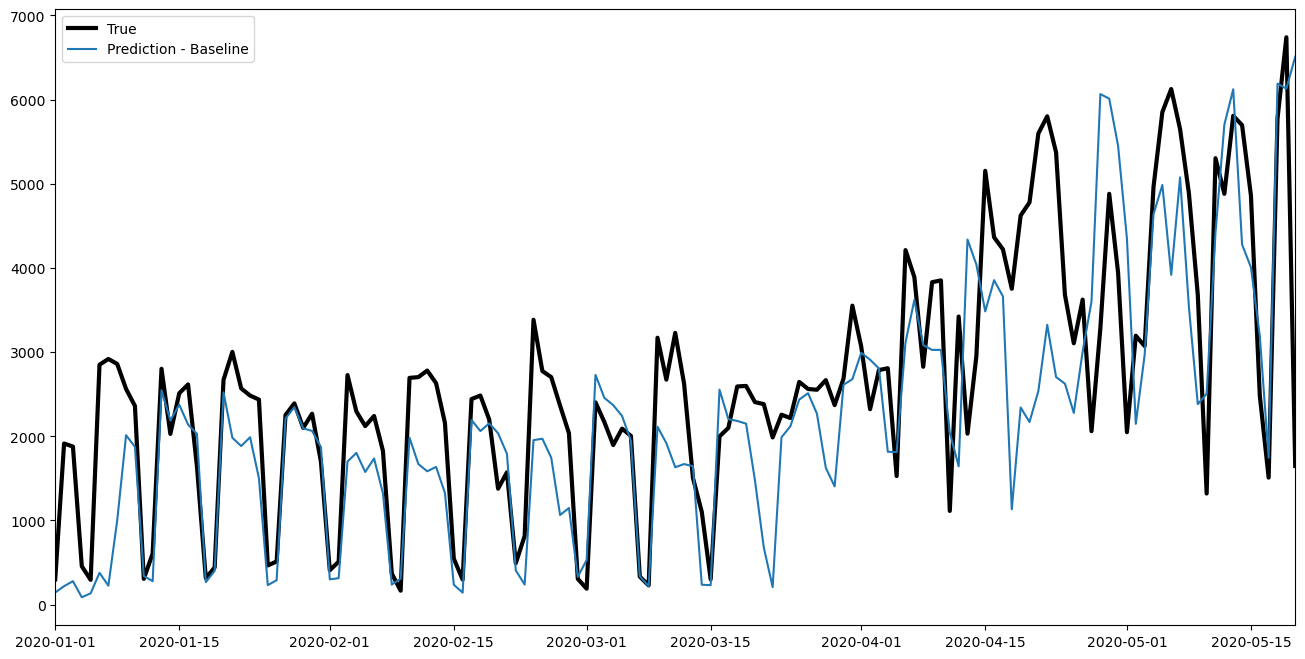

In [40]:
def plot_prediction_vs_true(yhat_list, yhat_names, ytest):
    plt.figure(figsize=(16, 8), dpi=100)
    plt.plot(ytest, color='black', label='True', linewidth=3)
    for yhat, yname in zip(yhat_list, yhat_names):
        plt.plot(yhat, label=f'Prediction - {yname}')
    plt.xlim([ytest.index.min(), ytest.index.max()])
    plt.legend(loc='upper left')
    plt.show()

plot_prediction_vs_true(yhat_list=[prediction_baseline],
                        yhat_names=['Baseline'],
                        ytest=y_test)

Let's create a function that calculates the cost caused by a bad forecast:

In [41]:
def Cost(y_true, y_pred):
        def apply_cost(x):
            if x < 0:
                x = np.abs(x)*10
            return x
        y_pred = np.round(y_pred)
        cost = y_pred - y_true
        cost = cost.apply(apply_cost)
        return np.sum(cost)

We will use this function in the Forecast evaluation function. It shouldn't contain anything new for you, we learned everything in the regression module. The purpose of this function is to visualize a plot of the forecast against the true value, a plot of the residuals against the true values, and a histogram of the residuals. In addition, we will also receive the output of the RMSE function on the test set and the reduced profit due to a bad forecast (we will use the Cost function we have just created for this purpose).

In [42]:
def model_evaluation(yhat, ytest):
    def fit_scatter_plot(yhat, ytest):
        xmin = ytest.min()
        xmax = ytest.max()
        plt.scatter(x = yhat, y = ytest, alpha=0.25)
        x_line = np.linspace(xmin, xmax, 10)
        y_line = x_line
        plt.plot(x_line, y_line, 'r--')
        plt.xlabel('Prediction')
        plt.ylabel('True value')
        plt.title(f'Plot of predictions against true values - Test set')
    def plot_of_residuals(yhat, ytest):
        errors = yhat - ytest
        plt.scatter(x = ytest, y = errors, alpha=0.25)
        plt.axhline(0, color="r", linestyle="--")
        plt.xlabel('True value')
        plt.ylabel('Residual')
        plt.title(f'Plot of residuals - Test set')
    def hist_of_residuals(yhat, ytest):
        errors = yhat - ytest
        plt.hist(errors, bins = 100)
        plt.axvline(errors.mean(), color='k', linestyle='dashed', linewidth=1)
        plt.title(f'Histogram of residuals - Test set')
    fig = plt.figure(figsize = (18, 6))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    ax = fig.add_subplot(1, 3, 1)
    fit_scatter_plot(yhat, ytest)
    ax = fig.add_subplot(1, 3, 2)
    plot_of_residuals(yhat, ytest)
    ax = fig.add_subplot(1, 3, 3)
    hist_of_residuals(yhat, ytest)
    plt.show()

    print(f'RMSE Test: {sqrt(mean_squared_error(ytest, yhat))}')
    print(f'Reduced profit: {Cost(ytest, yhat)}')

Let's use this function for the basic model, i.e. the one currently used by our bicycle rental company.



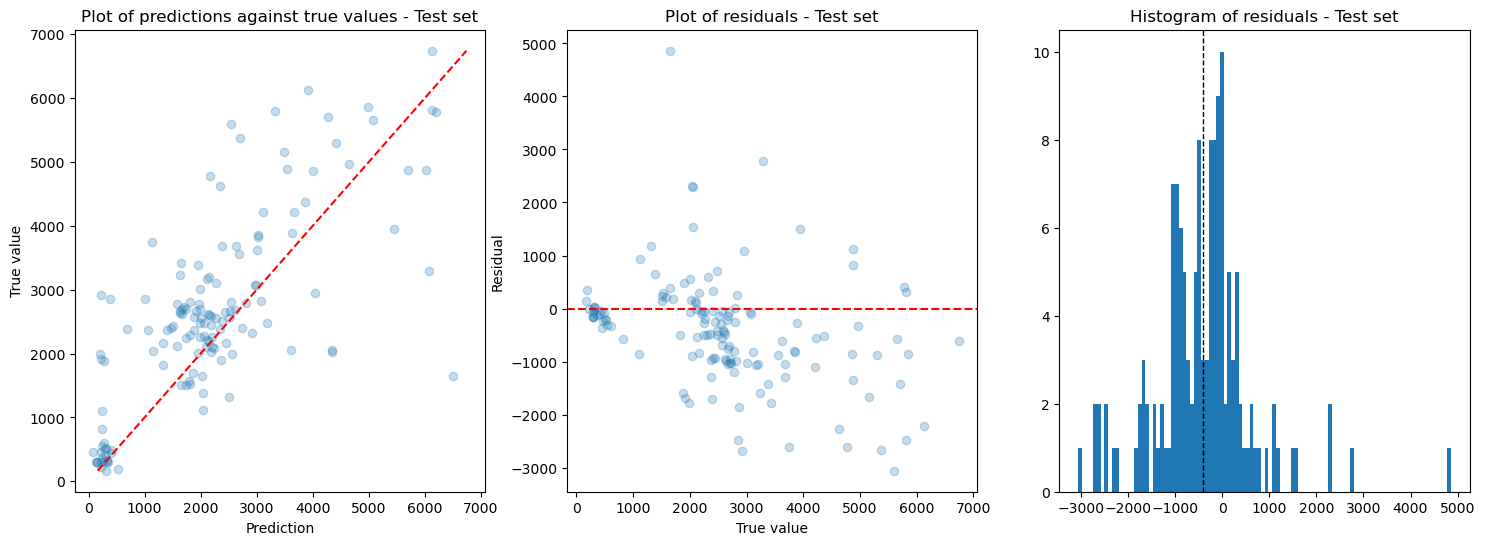

RMSE Test: 1127.9512337932003
Reduced profit: 884447.0


In [43]:
model_evaluation(yhat=prediction_baseline, ytest=y_test)

Unfortunately, due to an incorrect forecast, the profit of our business was reduced by PLN 884,447 in the period from January 1, 2020 to January 20, 2020.

## Decision Tree

Before we train the model, let's create our own 'scorer', which we will try to minimize with our models. It will be based on a function that calculates the cost resulting from an incorrect forecast.

In [45]:
cost_scorer = make_scorer(Cost, greater_is_better=False)

We use TimeSeriesSplit to divide into validation sets.

In [46]:
tree = DecisionTreeRegressor(random_state=2022)
params = {'max_depth': [2, 3, 5, 7, 10],
          'min_samples_leaf': [2, 3, 5, 7, 10]}
tree_gridsearch = GridSearchCV(tree,
                               params,
                               scoring=cost_scorer,
                               cv=TimeSeriesSplit(n_splits=5).split(X_train),
                               verbose=10,
                               n_jobs=-1)
tree_gridsearch.fit(X_train, y_train)
print('\nThe best hyperparameters:', tree_gridsearch.best_params_)
tree_model = tree_gridsearch.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits

The best hyperparameters: {'max_depth': 5, 'min_samples_leaf': 2}


Now let's make a prediction on the test set using the decision tree model we just learned.

In [47]:
prediction_tree = tree_model.predict(X_test)
prediction_tree = pd.Series(prediction_tree, index=y_test.index)
prediction_tree

2020-01-01     195.750000
2020-01-02    1894.000000
2020-01-03    1894.000000
2020-01-04     227.720339
2020-01-05     227.720339
                 ...     
2020-05-16    3191.152941
2020-05-17    1650.627273
2020-05-18    4062.000000
2020-05-19    4135.896000
2020-05-20    5970.966667
Length: 141, dtype: float64

First, let's visualize the true value predictions.

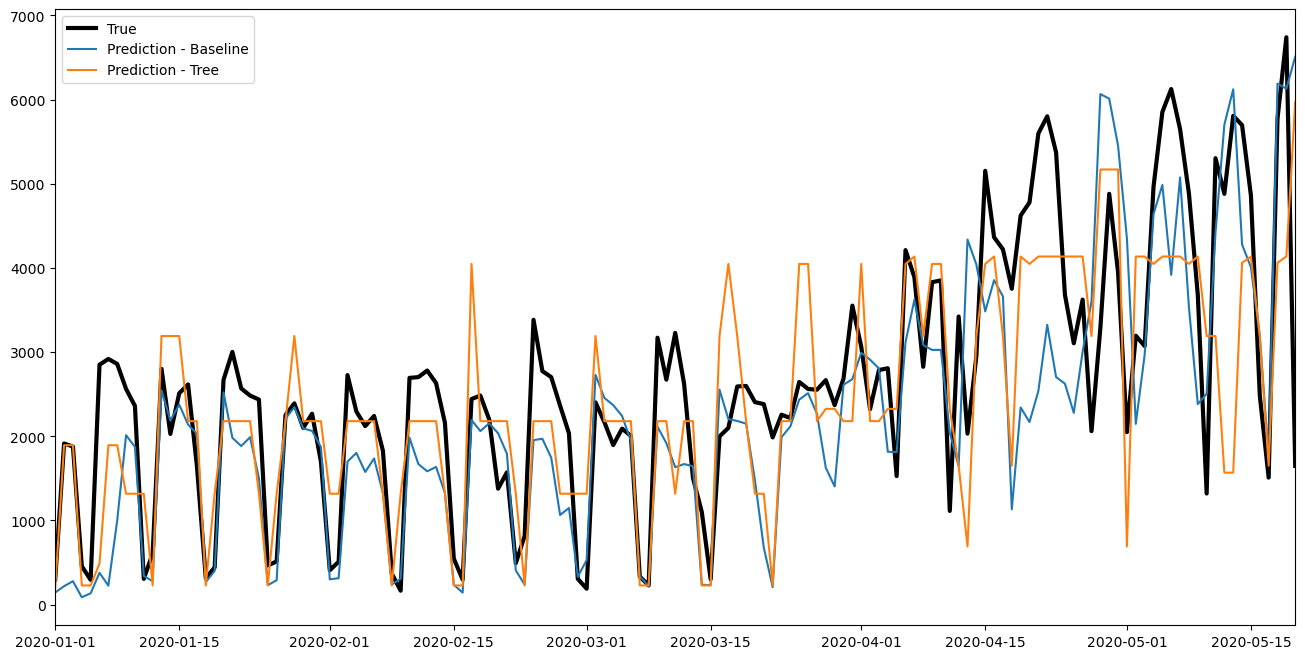

In [48]:
plot_prediction_vs_true(yhat_list=[prediction_baseline, prediction_tree],
                        yhat_names=['Baseline', 'Tree'],
                        ytest=y_test)

The forecast of the baselin model looks more natural, the decision tree, in accordance with its nature, creates 'staircases' for a regression problem.



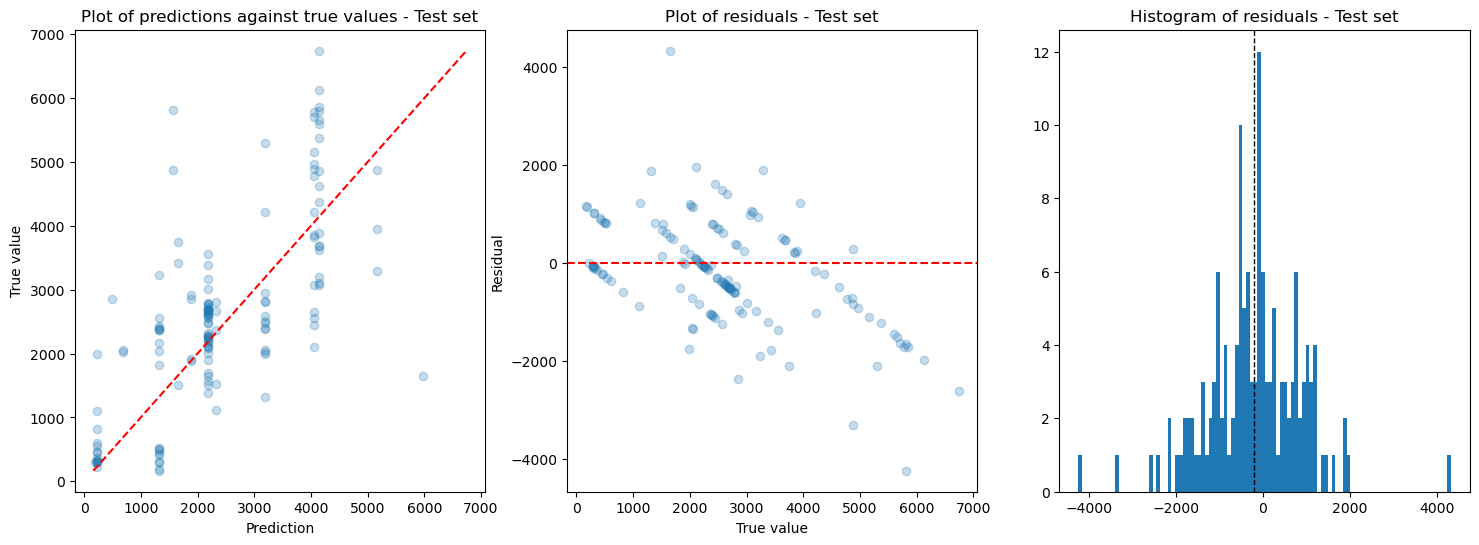

RMSE Test: 1111.67036404609
Reduced profit: 768402.0


In [49]:
model_evaluation(yhat=prediction_tree, ytest=y_test)

## Random forest

The decision tree has already produced better results than the base model, now it's time to see how Random Forest performs. The hyperparameter grid will be the same and the number of estimators will be set to 1000.

In [50]:
forest = RandomForestRegressor(n_estimators=1000, random_state=2022)
params = {'max_depth': [2, 3, 5, 10],
          'min_samples_leaf': [3, 5, 10, 15]}
forest_gridsearch = GridSearchCV(forest,
                                 params,
                                 scoring=cost_scorer,
                                 cv=TimeSeriesSplit(n_splits=5).split(X_train),
                                 verbose=10,
                                 n_jobs=-1)
forest_gridsearch.fit(X_train, y_train)
print('\nThe best hyperparameters:', forest_gridsearch.best_params_)
forest_model = forest_gridsearch.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits

The best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 3}


now it's time to make the forecast and then visualize the forecast against the true value and the forecasts of previous models.

In [51]:
prediction_forest = forest_model.predict(X_test)
prediction_forest = pd.Series(prediction_forest, index=y_test.index)
prediction_forest

2020-01-01     490.755887
2020-01-02    1660.802109
2020-01-03    1694.669199
2020-01-04     203.424211
2020-01-05     193.491012
                 ...     
2020-05-16    3147.245072
2020-05-17    1706.705057
2020-05-18    4817.861433
2020-05-19    4849.870314
2020-05-20    5680.537213
Length: 141, dtype: float64

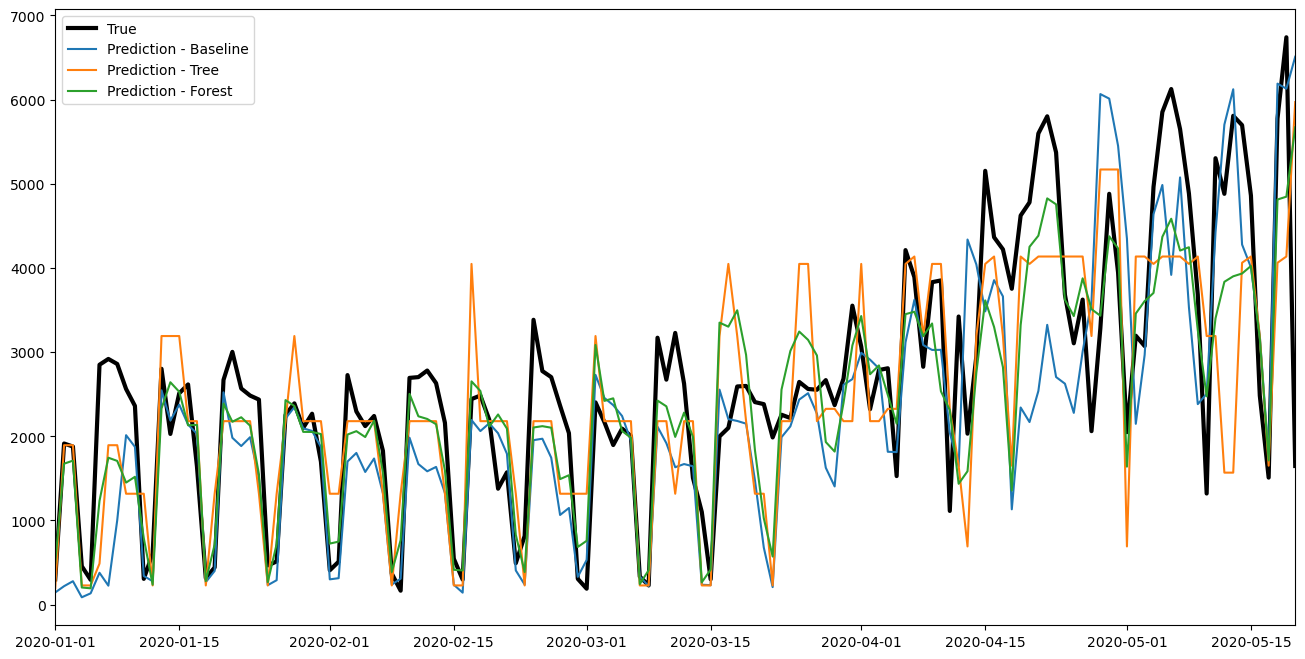

In [50]:
plot_prediction_vs_true(yhat_list=[prediction_baseline, prediction_tree, prediction_forest],
                        yhat_names=['Baseline', 'Tree', 'Forest'],
                        ytest=y_test)

The forecast looks really good, but each model has a problem when forecasting values ​​from mid-April - it would be worth verifying why. Perhaps the model is missing some information that would improve the quality of the forecast.

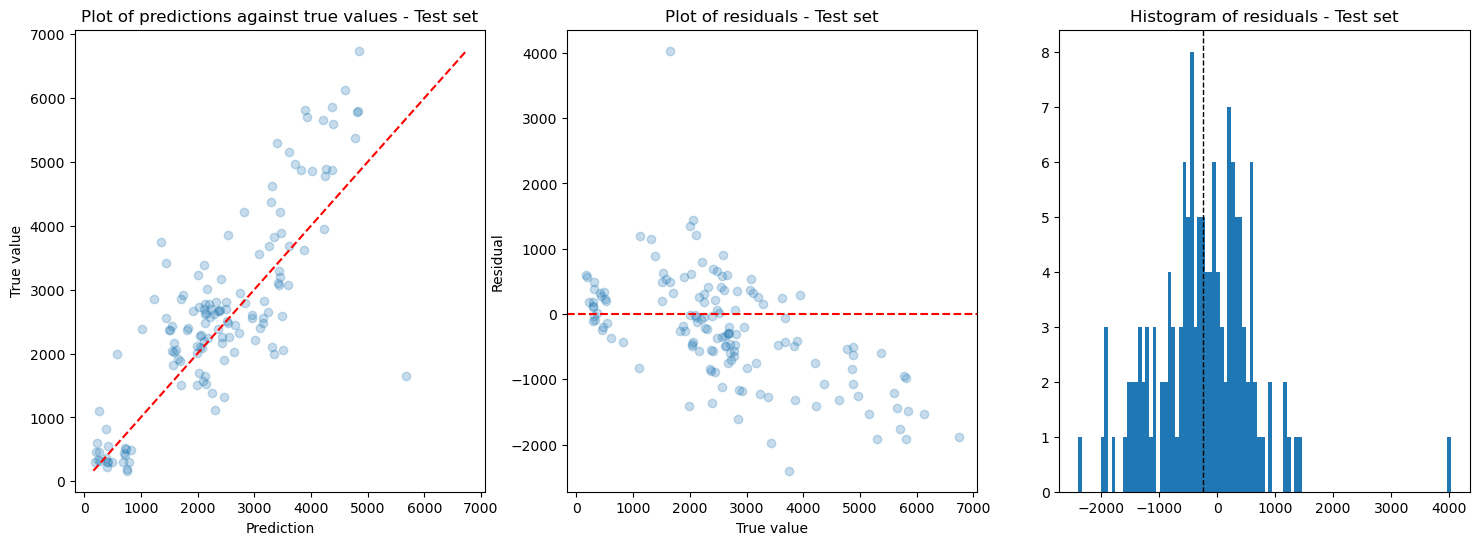

RMSE Test: 867.2687276309763
Reduced profit: 663256.0


In [52]:
model_evaluation(yhat=prediction_forest, ytest=y_test)

## Model interpretation

We know that our model can make a forecast, but we often want to understand what impact variables have on the value of the final forecast. For this we will use Shapley values, a technique taken from game theory (cf https://christophm.github.io/interpretable-ml-book/shap.html)

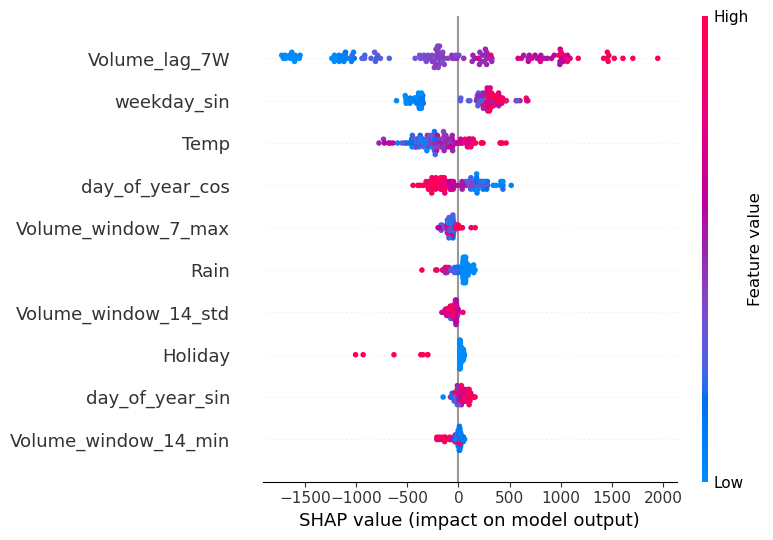

In [55]:
explainer = shap.TreeExplainer(forest_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Take a look at the temperature for example, higher values ​​have a positive impact on the forecast. This is different with rain, where higher values have a negative impact on the forecast. In addition, we can notice that temperature has a greater impact on the final value.